In [1]:
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit, hessian, lax, config
from jax.example_libraries import optimizers
from jax.nn import relu
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
from pathlib import Path

from scipy.interpolate import griddata
%matplotlib inline

In [2]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample
        self.y = y # location
        self.s = s # labeled data evulated at y (solution measurements, BC/IC conditions, etc.)
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [3]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [4]:
# Define the model
class DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)  # or Relu 
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)     # or Relu

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=2000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, x, t):
        branch_params, trunk_params = params
        y = np.stack([x, t])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return  outputs
  
    # Define operator loss
    def loss_operator(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred.flatten())**2)
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss_operator)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        # Define data iterators
        data_iterator = iter(dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            batch = next(data_iterator)
           
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute loss
                loss_value = self.loss_operator(params, batch)

                # Store loss
                self.loss_log.append(loss_value)
  
                # Print loss
                pbar.set_postfix({'Loss': loss_value})
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

In [5]:
# Use double precision to generate data (due to GP sampling)
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

# A diffusion-reaction numerical solver
def solve_ADR(key, Nx, Nt, P, length_scale):
    """Solve 1D
    u_t = (k(x) u_x)_x - v(x) u_x + g(u) + f(x)
    with zero initial and boundary conditions.
    """
    xmin, xmax = 0, 1
    tmin, tmax = 0, 1
    k = lambda x: 0.01*np.ones_like(x)
    v = lambda x: np.zeros_like(x)
    g = lambda u: 0.01*u ** 2
    dg = lambda u: 0.02 * u
    u0 = lambda x: np.zeros_like(x)

    # Generate subkeys
    subkeys = random.split(key, 2)

    # Generate a GP sample
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(xmin, xmax, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(subkeys[0], (N,)))
    # Create a callable interpolation function  
    f_fn = lambda x: np.interp(x, X.flatten(), gp_sample)

    # Create grid
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    h2 = h ** 2

    # Compute coefficients and forcing
    k = k(x)
    v = v(x)
    f = f_fn(x)

    # Compute finite difference operators
    D1 = np.eye(Nx, k=1) - np.eye(Nx, k=-1)
    D2 = -2 * np.eye(Nx) + np.eye(Nx, k=-1) + np.eye(Nx, k=1)
    D3 = np.eye(Nx - 2)
    M = -np.diag(D1 @ k) @ D1 - 4 * np.diag(k) @ D2
    m_bond = 8 * h2 / dt * D3 + M[1:-1, 1:-1]
    v_bond = 2 * h * np.diag(v[1:-1]) @ D1[1:-1, 1:-1] + 2 * h * np.diag(
        v[2:] - v[: Nx - 2]
    )
    mv_bond = m_bond + v_bond
    c = 8 * h2 / dt * D3 - M[1:-1, 1:-1] - v_bond

    # Initialize solution and apply initial condition
    u = np.zeros((Nx, Nt))
    u = u.at[np.index_exp[:,0]].set(u0(x))
    # Time-stepping update
    def body_fn(i, u):
        gi = g(u[1:-1, i])
        dgi = dg(u[1:-1, i])
        h2dgi = np.diag(4 * h2 * dgi)
        A = mv_bond - h2dgi
        b1 = 8 * h2 * (0.5 * f[1:-1] + 0.5 * f[1:-1] + gi)
        b2 = (c - h2dgi) @ u[1:-1, i].T
        u = u.at[np.index_exp[1:-1, i + 1]].set(np.linalg.solve(A, b1 + b2))
        return u
    # Run loop
    UU = lax.fori_loop(0, Nt-1, body_fn, u)

    # Input sensor locations and measurements
    xx = np.linspace(xmin, xmax, m)
    u = f_fn(xx)
    # Output sensor locations and measurements
    idx = random.randint(subkeys[1], (P, 2), 0, max(Nx, Nt))
    y = np.concatenate([x[idx[:,0]][:,None], t[idx[:,1]][:,None]], axis = 1)
    s = UU[idx[:,0], idx[:,1]]
    # x, t: sampled points on grid
    return (x, t, UU), (u, y, s)

# Geneate training data corresponding to one input sample
def generate_one_training_data(key, P):
    # Numerical solution
    (x, t, UU), (u, y, s) = solve_ADR(key, Nx , Nt, P, length_scale)

    u = np.tile(u, (P, 1))

    return u, y, s

# Geneate test data corresponding to one input sample
def generate_one_test_data(key, P):
    Nx = P
    Nt = P
    (x, t, UU), (u, y, s) = solve_ADR(key, Nx , Nt, P, length_scale)

    XX, TT = np.meshgrid(x, t)

    u_test = np.tile(u, (P**2, 1))
    y_test = np.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = UU.T.flatten()

    return u_test, y_test, s_test

# Geneate training data corresponding to N input sample
def generate_training_data(key, N, P):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    u_train, y_train, s_train= vmap(generate_one_training_data, (0, None))(keys, P)

    u_train = np.float32(u_train.reshape(N * P, -1))
    y_train = np.float32(y_train.reshape(N * P, -1))
    s_train = np.float32(s_train.reshape(N * P, -1))

    config.update("jax_enable_x64", False)
    return u_train, y_train, s_train

# Geneate test data corresponding to N input sample
def generate_test_data(key, N, P):

    config.update("jax_enable_x64", True)
    keys = random.split(key, N)

    u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, P)

    u_test = np.float32(u_test.reshape(N * P**2, -1))
    y_test = np.float32(y_test.reshape(N * P**2, -1))
    s_test = np.float32(s_test.reshape(N * P**2, -1))

    config.update("jax_enable_x64", False)
    return u_test, y_test, s_test

# Compute relative l2 error over N test samples.
def compute_error(key, P):
    # Generate one test sample
    u_test, y_test, s_test = generate_test_data(key, 1, P)
    # Predict  
    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    # Compute relative l2 error
    error_s = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 
    return error_s

In [6]:
key = random.PRNGKey(0)

# GRF length scale
length_scale = 0.2

# Resolution of the solution
Nx = 100
Nt = 100

N = 5000 # number of input samples
m = Nx   # number of input sensors
P_train = 100 # number of output sensors

u_train, y_train, s_train = generate_training_data(key, N, P_train)

In [7]:
print(u_train.shape)
print(u_train)

(500000, 100)
[[-0.16287889 -0.2409193  -0.3230347  ...  2.0485687   2.0846038
   2.112243  ]
 [-0.16287889 -0.2409193  -0.3230347  ...  2.0485687   2.0846038
   2.112243  ]
 [-0.16287889 -0.2409193  -0.3230347  ...  2.0485687   2.0846038
   2.112243  ]
 ...
 [-1.3333012  -1.3544134  -1.3681227  ...  0.18361774  0.17091674
   0.16504906]
 [-1.3333012  -1.3544134  -1.3681227  ...  0.18361774  0.17091674
   0.16504906]
 [-1.3333012  -1.3544134  -1.3681227  ...  0.18361774  0.17091674
   0.16504906]]


In [8]:
print(y_train.shape)
print(y_train)

(500000, 2)
[[0.4848485  0.7171717 ]
 [0.2929293  0.8181818 ]
 [0.8181818  0.3030303 ]
 ...
 [0.94949496 0.61616164]
 [0.6060606  0.86868685]
 [0.6262626  0.05050505]]


In [9]:
print(s_train.shape)
print(s_train)

(500000, 1)
[[-0.9712199 ]
 [-1.5985669 ]
 [ 0.15218662]
 ...
 [ 0.11742333]
 [-0.22049907]
 [-0.01859999]]


In [10]:
# Initialize model
branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [2, 50, 50, 50, 50, 50]
model = DeepONet(branch_layers, trunk_layers)

In [11]:
# Create data set
batch_size = 10000
dataset = DataGenerator(u_train, y_train, s_train, batch_size)

In [13]:
# Train
model.train(dataset, nIter=40000)

100%|██████████| 40000/40000 [01:26<00:00, 463.68it/s, Loss=5.662937e-05]  


In [14]:
params = model.get_params(model.opt_state)

path = Path('TrainedModels/deeponet')
path.mkdir(parents=True, exist_ok=True)

# Save the trained model
flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
np.save(path/'dr_params.npy', flat_params)
np.save(path/'dr_loss.npy', model.loss_log)

# Restore the trained model
flat_params = np.load(path/'dr_params.npy')
params = model.unravel_params(flat_params)

In [15]:
# Test data
N_test = 100 # number of input samples 
P_test = m   # number of sensors 
key_test = random.PRNGKey(1234567)
keys_test = random.split(key_test, N_test)

# Predict
params = model.get_params(model.opt_state)

# Compute error
error_s = vmap(compute_error, (0, None))(keys_test,P_test) 

print('mean of relative L2 error of s: {:.2e}'.format(error_s.mean()))
print('std of relative L2 error of s: {:.2e}'.format(error_s.std()))

mean of relative L2 error of s: 2.02e-02
std of relative L2 error of s: 1.44e-02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


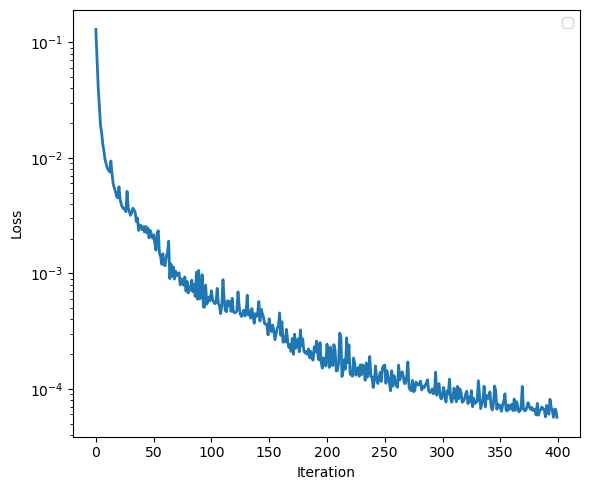

In [16]:
#Plot for loss function
plt.figure(figsize = (6,5))
plt.plot(model.loss_log, lw=2)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Generate one test sample
key = random.PRNGKey(12345)
P_test = 100
Nx = m
u_test, y_test, s_test = generate_test_data(key, 1, P_test)

# Predict
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)

# Generate an uniform mesh
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)

# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')

# Compute the relative l2 error 
error = np.linalg.norm(S_pred - S_test, 2) / np.linalg.norm(S_test, 2) 
print('Relative l2 errpr: {:.3e}'.format(error))

Relative l2 errpr: 3.012e-02


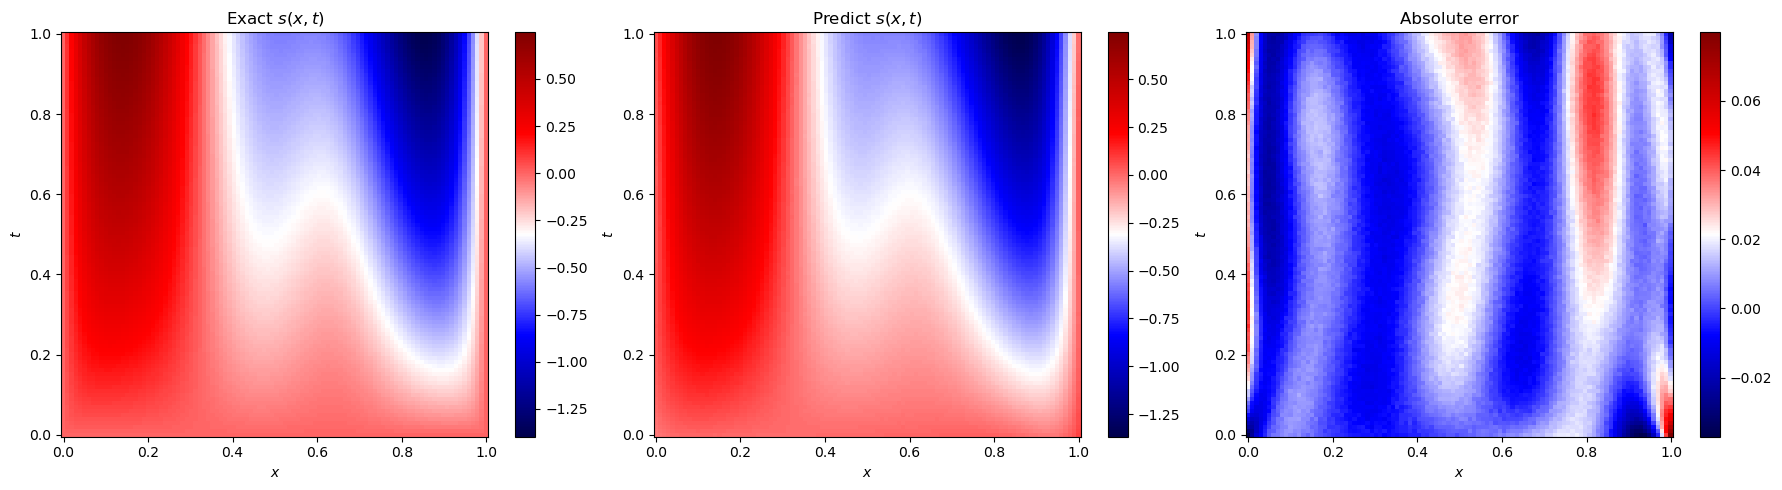

In [18]:
# Plot
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.pcolor(XX,TT, S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
plt.pcolor(XX,TT, S_pred, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
plt.pcolor(XX,TT, S_pred - S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()